In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter

df = pd.read_csv('final.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36330 entries, 0 to 36329
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   icustay_id                   36330 non-null  int64  
 1   day_28_flag                  36330 non-null  int64  
 2   icu_exp_flag                 36330 non-null  int64  
 3   day_28_after_discharge_flag  36330 non-null  int64  
 4   ethnicity                    36330 non-null  object 
 5   gender                       36330 non-null  object 
 6   age                          36330 non-null  float64
 7   length_of_stay               36330 non-null  float64
 8   service_type                 36330 non-null  object 
 9   weight                       36330 non-null  float64
 10  height                       36330 non-null  float64
 11  sofa                         36330 non-null  int64  
 12  DiasBP                       36330 non-null  float64
 13  HeartRate       

In [2]:
id_col = 'icustay_id'

target_col = 'day_28_after_discharge_flag'

#20 numerical columns
numerical_cols = ['age', 'length_of_stay', 'sofa', 'DiasBP', 'HeartRate', 'MAP', 'SpO2',
                 'SysBP', 'Temperature', 'BUN', 'CHLORIDE', 'CREATININE', 'HEMOGLOBIN', 'PLATELET', 'POTASSIUM',
                 'SODIUM', 'TOTALCO2', 'WBC', 'bmi', 'eGFR']

#2 categorical columns
categorical_cols = ['gender', 'service_type']

In [3]:
# combine the functions above
# check categorical columns
def explore_categorical_columns(df,categorical_cols):
    nunique_values = []
    na_values = []
    for col in categorical_cols:
        nunique_values.append(df[col].nunique())
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_categorical = pd.DataFrame(list(zip(categorical_cols,nunique_values,na_values)),columns=['Column_Name','#Unique_Values','#Null_Value'])
    df_null = df_stats_categorical[df_stats_categorical['#Null_Value']>0]
    df_unique_value = df_stats_categorical[df_stats_categorical['#Unique_Values'] == 1]
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the categorical columns')
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value['Column_Name']))))
    else:
        print('All categorical columns have more than 1 value.')
        
#check numerical columns
def explore_numerical_columns(df,numerical_cols):
    na_values = []
    for col in numerical_cols:
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_numerical = pd.DataFrame(list(zip(numerical_cols,na_values)),columns=['Column_Name','#Null_Value'])
    df_null = df_stats_numerical[df_stats_numerical['#Null_Value']>0]
    df_stats = df[numerical_cols].describe().T
    df_unique_value = df_stats[df_stats['std']==0]
    
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the numerical columns')
    
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value.index))))
    else:
        print('All numerical columns have more than 1 value. \n')

#check categorical columns
print('Categorical_Columns'.center(50,"*"))
explore_categorical_columns(df,categorical_cols)
print('Numerical_Columns'.center(50,"*"))
#check numerical columns
explore_numerical_columns(df,numerical_cols)

***************Categorical_Columns****************
There is no Null values in the categorical columns
All categorical columns have more than 1 value.
****************Numerical_Columns*****************
There is no Null values in the numerical columns
All numerical columns have more than 1 value. 



In [4]:
# Check target variable
df[target_col].unique()

array([0, 1])

In [5]:
# Check class imbalance
df[target_col].value_counts()

0    33746
1     2584
Name: day_28_after_discharge_flag, dtype: int64

In [6]:
df_features = pd.concat([df[numerical_cols], df[categorical_cols]],axis=1)
df_labels = df[target_col]

# K-Nearest Neighbours with SMOTE-NC

In [7]:
# Baseline K-Nearest Neighbours Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
testscore = []
recall = []
auc = []

for i in range(30):
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Standardisation
    scale_numerical_cols = df_features[numerical_cols].columns
    scaler = StandardScaler().fit(train_x[numerical_cols])
    numerical_train_x = pd.DataFrame(scaler.transform(train_x[numerical_cols]),columns=scale_numerical_cols)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = pd.DataFrame(scaler.transform(test_x[numerical_cols]),columns=scale_numerical_cols)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)

    knc = KNeighborsClassifier()
    knc.fit(X, y)
    
    # test_accuracy_base
    testscore.append(knc.score(X_test,y_test))
    y_true_base, y_pred_base = y_test , knc.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_base, y_pred_base))
    
    probs_base = knc.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_base, tpr_base))

print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

Test set score: 0.747 +/- 0.003
Recall: 0.567 +/- 0.023
AUC: 0.717 +/- 0.009


# Hyperparameters Tuning - SMOTE-NC

In [7]:
# Tuning number of neighbours

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import time

start_time = time.time()

neighbors = [int(x) for x in np.linspace(start = 1, stop = 50, num = 5)]
oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
test_total = []
recall_total = []
auc_total = []

for i in range(30):
    test = []
    recall = []
    auc = []
    
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Standardisation
    scale_numerical_cols = df_features[numerical_cols].columns
    scaler = StandardScaler().fit(train_x[numerical_cols])
    numerical_train_x = pd.DataFrame(scaler.transform(train_x[numerical_cols]),columns=scale_numerical_cols)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = pd.DataFrame(scaler.transform(test_x[numerical_cols]),columns=scale_numerical_cols)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)
    
    for n in neighbors:
        knc = KNeighborsClassifier(n_neighbors=n)
        knc.fit(X, y)
    
        # test_accuracy_base
        test.append(knc.score(X_test,y_test))
        y_true_gs, y_pred_gs = y_test, knc.predict(X_test)
    
        # recall_base 
        recall.append(recall_score(y_true_gs, y_pred_gs))
    
        probs_gs = knc.predict_proba(X_test)
        preds_gs = probs_gs[:,1]
        fpr_gs, tpr_gs, threshold = metrics.roc_curve(y_true_gs, preds_gs)
    
        # roc_auc_base 
        auc.append(metrics.auc(fpr_gs, tpr_gs))
    
    test_total.append(test)
    recall_total.append(recall)
    auc_total.append(auc)

test_total = list(zip(*test_total))
recall_total = list(zip(*recall_total))
auc_total = list(zip(*auc_total))

test_mean = [mean(x) for x in test_total]
recall_mean = [mean(x) for x in recall_total]
auc_mean = [mean(x) for x in auc_total]

print('Time taken for training the model: '+ str(time.time() - start_time))

Time taken for training the model: 6860.577443361282


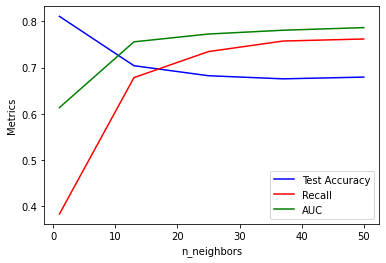

In [8]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt

plt.plot(neighbors, test_mean, color='b', label='Test Accuracy')
plt.plot(neighbors, recall_mean, color='r', label='Recall')
plt.plot(neighbors, auc_mean, color='g', label='AUC')
plt.legend(loc = 'best')
plt.ylabel('Metrics')
plt.xlabel('n_neighbors')
plt.show()

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from statistics import mean
from statistics import stdev 

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
testscore = []
recall = []
auc = []

for i in range(30):
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)
    
    # Standardisation
    scale_numerical_cols = df_features[numerical_cols].columns
    scaler = StandardScaler().fit(train_x[numerical_cols])
    numerical_train_x = pd.DataFrame(scaler.transform(train_x[numerical_cols]),columns=scale_numerical_cols)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = pd.DataFrame(scaler.transform(test_x[numerical_cols]),columns=scale_numerical_cols)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)
    
    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)
    
    n = [int(x) for x in np.linspace(start = 16, stop = 25, num = 10)]
    knc = KNeighborsClassifier()
    param_dist = {'n_neighbors': n}

    gs_knc = GridSearchCV(knc, param_dist, cv = 5, verbose = 1, n_jobs=-1)

    gs_knc.fit(X, y)
    knc_gs = gs_knc.best_estimator_.fit(X, y)
    
    # test_accuracy_base
    testscore.append(knc_gs.score(X_test,y_test))
    y_true_gs, y_pred_gs = y_test, knc_gs.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_gs, y_pred_gs))
    
    probs_gs = knc_gs.predict_proba(X_test)
    preds_gs = probs_gs[:,1]
    fpr_gs, tpr_gs, threshold = metrics.roc_curve(y_true_gs, preds_gs)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_gs, tpr_gs))

print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


Test set score: 0.713 +/- 0.005
Recall: 0.673 +/- 0.017
AUC: 0.761 +/- 0.008
